### QTM 350 Project
### Using Global NOAA to Analyze Change in our Climate and Society

##### by Karoline Lin, Rachel Shanahan, John Cox, Erin O'Reilly, Hayley Roesler
##### on April 27, 2020


In [3]:
!pip install jupyterthemes
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('oceans16')
!jt -t oceans16

    100% |████████████████████████████████| 7.0MB 4.4MB/s eta 0:00:01
    100% |████████████████████████████████| 9.0MB 3.6MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 26.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for prometheus-client ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
Successfully built prometheus-client
typing-extensions 3.7.4.1 has requirement typing>=3.7.4; python_version < "3.5", but you'll have typing 3.6.4 which is incompatible.
  Found existing installation: notebook 5.5.0
    Uninstalling notebook-5.5.0:
      Successfully uninstalled notebook-5.5.0
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from IPython.display import display, Markdown, Image

In [5]:
image_bucket = 'global-noaa'

In [6]:
def show_image(bucket, key, img_width = 500):
    return Image(url='https://s3.amazonaws.com/' + bucket + '/' + key, width=img_width)


In [7]:
show_image(image_bucket, 'NOAA.png', 400)

# Motivation Behind This Project

With the increasing urgency for us, as citizens of the world, to pay attention to the ways in which our planet is changing before us, it is imperative that we pay attention to the data that we do have. As April 22, 2020 was Earth Day, we thought it was opportune to look at the NOAA Integrated Surface Database (ISD) that can be found on Amazon Web Service’s open data registry. This data is compiled from a series of over 35,000 stations worldwide, and is constantly being updated daily. 

We decided that in an effort to create a cohesive understanding of our climate over time, it would be appropriate to compare a weather station over multiple years and various observations. This way, with the same elevation and location at our disposal, we might be able to locate possible trends or differences in the output of our findings as well as the frequency of observations. We thought that it might be interesting to look at Sirte, Libya, as our location of interest. Sirte is a coast city located in Northern Libya. As a place that gets a mixture of climate being in a desert and located adjacent to the Mediterranean, we thought that this might be an interesting climate to analyze.

The NOAA, which is our National Ocean and Atmospheric Administration, is a federal U.S. agency that is responsible for monitoring and trying to improve our environment and climate. The NOAA data is responsible for driving industries worth billions of dollars as well important research initiatives. Through public accessibility, NOAA hopes to cultivate a system of innovation among data scientists and environmentalists alike. As individuals of this targeted audience of data science users, we thought it would be interesting and inspiring to see what we could do with data of this magnitude and importance at our disposal.

In [ ]:
show_image(image_bucket, ‘sirte.png', 400)

# Analysis

### Setting Up Our Notebook

We used the template notebooks provided in class to help assist us in the creation of our own blog dedicated to NOAA’s surface temperature research. These templates can be found in Manav Seghal’s repository dedicated AWS open data. These include “Exploring data with Python and Amazon S3 select” https://github.com/aws-samples/aws-open-data-analytics-notebooks/tree/master/exploring-data as well as using “AI Services for Analyzing Public Data” https://github.com/aws-samples/aws-open-data-analytics-notebooks/tree/master/ai-services/. These notebooks helped us better frame our blog as they served as a jumpstart toward our researching techniques.

Above, we also created an S3 bucket to store the pictures we are including in this Jupyter and named it global-noaa.

To begin our analysis of this data, we went through a series of steps to set up our notebook environment and the tools that we would need to import the large database into our SageMaker. This included importing boto3, botocore, pandas, display, and Markdown (just to start).

In [26]:
import boto3
import botocore
import pandas as pd

We created an S3 bucket that we wanted to work with, and named it after the name of the dataset we would be using so that it would be easy to discern.

In [27]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

In [28]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

### Getting the Data

Using the Amazon Resource Name (ARN), listed in both the online data AWS registry and the github repository containing all of the open-access dataset, we pulled the dataset that we wanted. Our bucket that we pulled using the ARN for this particular dataset was called “global-noaa-hourly-pds”. From this, we were able to import and download the exact CSV files that we wanted to work with. The particular station number that we decided to look at was “62019099999” which is located in Sirte, Libya.

In [1]:
create_bucket('open-data-analytics-noaa-globalQTM350')

NameError: name 'create_bucket' is not defined

In [30]:
def list_buckets(match=''):
    response = s3.list_ibuckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')

SyntaxError: invalid syntax (<ipython-input-30-e74d55d03b29>, line 4)

In [31]:
list_buckets(match='open')

NameError: name 'list_buckets' is not defined

In [32]:
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

SyntaxError: invalid syntax (<ipython-input-32-a91419a8d7dd>, line 19)

In [33]:
#str(list_bucket_contents(bucket='noaa-global-hourly-pds', match='', size_mb=250)).split()

The command above lists the contents and data size of each bucket; we put this command in markdown for now as it produces a huge number of CSV files. We do not need to run this command everytime for our jupyter notebook to successfully run. We will not run this for now as it will save a lot of space and scrolling in our jupyter notebook for our personal convenience and the convenience of any reader or user.

In [34]:
show_image(image_bucket, 'earth1.jpg', 600)

Our Earth is our most vital asset; it is upon us to take care of our planet to the best of our ability. The data that NOAA collects is vital for the purpose of informing environmentalists and common citizens, in general, as well as pushing forth important policies to better our planet. Below, we will run code to preview and import our datasets so that we might look and analyze the specific numerical data collected by NOAA. Having free access to this data is an opportunity for us as students to hit the ground run with understanding global climate change trends as well as proposing new initiatives and campaigns to help our Earth.

In [41]:
def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data

From here, we combined all of our datasets that we were using into a single data frame using the append command. At this point, we decided to make several manipulations of our dataset in order to better understand climate trends. Our data that we combined looked at the same station in Libya sampled every ten years. From these observations, we were able to note and pick apart a variety of trends that we saw among the data.

In [42]:
# create starting data frame: station 62019099999, year 1950
df = preview_csv_dataset(bucket='noaa-global-hourly-pds', key= '1950/62019099999.csv', rows=100)

# create new column for year
df['YEAR'] = '1950'

In [43]:
# Looking at station 62019099999
# Manually select and combine every 10 years of station's data
year_list = [1960, 1973, 1980, 1990, 2000, 2010, 2020]
for year in year_list:
    df_temp = preview_csv_dataset(bucket='noaa-global-hourly-pds', key= str(year) + '/62019099999.csv', rows=100)
    df_temp['YEAR'] = str(year)
    df = pd.concat([df, df_temp])

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The commands run below produces our combined dataframe, which pulls climate samples from the same station in Libya about every 10 years

In [160]:
# clean up columns to eventually compare this station's data by year
columns = ['STATION', 'DATE', 'YEAR', 'SOURCE','LATITUDE','LONGITUDE','TMP','ELEVATION','WND','NAME']
df = pd.DataFrame(df, columns = columns)
# Show first 10 row of dataframe to see what it looks like
df.head(10)

,STATION,DATE,YEAR,SOURCE,LATITUDE,LONGITUDE,TMP,ELEVATION,WND,NAME
0,62019099999,1950-01-03T12:00:00,1950,4,31.2,16.583333,"+0178,1",14.0,"270,1,N,0026,1","SIRTE, LY"
1,62019099999,1950-01-04T12:00:00,1950,4,31.2,16.583333,"+0167,1",14.0,"290,1,N,0067,1","SIRTE, LY"
3,62019099999,1950-01-08T12:00:00,1950,4,31.2,16.583333,"+0189,1",14.0,"340,1,N,0046,1","SIRTE, LY"
4,62019099999,1950-01-09T12:00:00,1950,4,31.2,16.583333,"+0161,1",14.0,"230,1,N,0010,1","SIRTE, LY"
5,62019099999,1950-01-11T12:00:00,1950,4,31.2,16.583333,"+0267,1",14.0,"080,1,N,0026,1","SIRTE, LY"
6,62019099999,1950-01-12T12:00:00,1950,4,31.2,16.583333,"+0172,1",14.0,"310,1,N,0010,1","SIRTE, LY"
7,62019099999,1950-01-13T12:00:00,1950,4,31.2,16.583333,"+0172,1",14.0,"050,1,N,0031,1","SIRTE, LY"
8,62019099999,1950-01-17T12:00:00,1950,4,31.2,16.583333,"+0161,1",14.0,"200,1,N,0046,1","SIRTE, LY"
10,62019099999,1950-01-19T12:00:00,1950,4,31.2,16.583333,"+0150,1",14.0,"999,9,9,9999,9","SIRTE, LY"
12,62019099999,1950-01-24T12:00:00,1950,4,31.2,16.583333,"+0189,1",14.0,"230,1,N,0010,1","SIRTE, LY"


In [45]:
show_image(image_bucket, 'ocean.jpg', 500)

### Cleaning the Data

We wanted to focus our analysis on the 'TMP' or temperature variable.  Therefore we started our cleaning there.

In [46]:
# clean temperature column from NOAA format into degrees Celsius
import re
df['TMP-Celsius'] = df['TMP']
df['TMP-Celsius'] = df['TMP-Celsius'].str.replace(r',\d', '')
df['TMP-Celsius'] = df['TMP-Celsius'].str.replace(r'\+', '')
df['TMP-Celsius'] = df['TMP-Celsius'].astype(float)
df['TMP-Celsius'] = df['TMP-Celsius'] / 100

Using our code above and the data from our appended dataframe, we formatted our temperature data in degrees Celsius so that it was easier to graph and deciper quickly.

After formatting the temperature, we searched for possible outliers or errors in the data.  We were able to identify one and omit it from the dataset.

In [52]:
# ground temperatures are not 99 degrees Celsius - remove outlier rows
indexNames = df[ df['TMP-Celsius'] == 99.99 ].index
df = df.drop(indexNames , inplace=False)

Next we found the summary statistics of temperature of each year in the dataset.

In [150]:
# average temperature by year
averages = df.groupby('YEAR')['TMP-Celsius'].mean()
averages = pd.DataFrame(averages)
sd = df.groupby('YEAR')['TMP-Celsius'].std()
sd = pd.DataFrame(sd)
sd = sd.rename(columns = {'TMP-Celsius': 'std'})
averages = pd.merge(left=averages, right=sd, left_on='YEAR', right_on='YEAR')
all = df.groupby('YEAR')['TMP-Celsius'].describe()

all

,count,mean,std,min,25%,50%,75%,max
YEAR,,,,,,,,
1950,82.0,2.170854,0.571429,1.50,1.7200,1.94,2.5000,3.94
1960,82.0,1.386585,0.320232,0.72,1.2200,1.39,1.6100,2.22
1973,82.0,1.481707,0.340344,0.70,1.3000,1.50,1.7000,2.50
1980,82.0,1.303659,0.342267,0.50,1.0250,1.40,1.5000,2.00
1990,82.0,1.448780,0.300442,0.80,1.2300,1.55,1.7000,2.00
2000,82.0,1.222317,0.203192,0.65,1.1000,1.23,1.3500,1.62
2010,82.0,1.697805,0.446551,0.68,1.4625,1.70,1.9275,2.95
2020,82.0,1.582805,0.301692,0.80,1.3600,1.60,1.7950,2.10


### Graphing our Data

The first thing we wanted to do when plotting our data is to check if there are any outlier temperature values that we missed.  An easy way to do this is to plot the max and min values for each year, and see if all the values are in a reasonable range.

<Figure size 3600x1440 with 0 Axes>

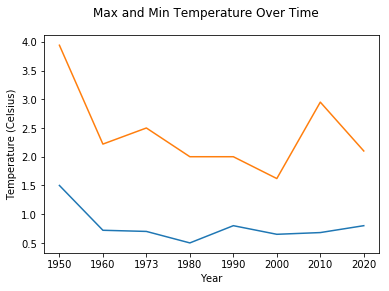

<Figure size 3600x1440 with 0 Axes>

In [157]:
plt.plot(all['min'])
plt.plot(all['max'])
plt.suptitle('Max and Min Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.figure(figsize=(50,20))

Looking at the above plot, all the max and min values seem to make sense, meaning there are no huge outliers.

In [90]:
# set up graphs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import sem 

<Figure size 3600x1440 with 0 Axes>

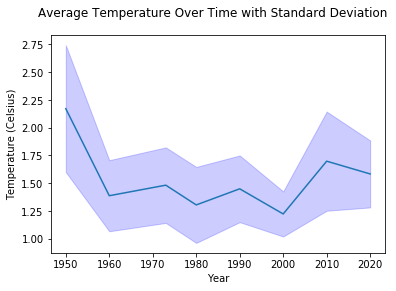

<Figure size 3600x1440 with 0 Axes>

In [158]:
# graph temperatures with standard deviation across years

years = [1950, 1960, 1973, 1980, 1990, 2000, 2010, 2020]
average_temp = averages['TMP-Celsius']
std = averages['std']
plt.fill_between(years, averages['TMP-Celsius'] - averages['std'], averages['TMP-Celsius'] + averages['std'], color='b', alpha=0.2)
plt.plot(years, average_temp)
plt.suptitle('Average Temperature Over Time with Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.figure(figsize=(50,20))

From the graph that we created above, we can see a sharp decline in average temperatures recorded in Sirte, Libya, over the course of the past seventy years. We typically imagine the concept of global warming as only capable of causing rising temperatures, that creates the loss of habitats for certain species of animals, particularly polar bears, as seen below. Climate changes can encompass a wide variety of different outcomes related to the degradation of our planet. The trend in declining temperatures in Libya that we see in our above graph can be related to a changing climate over time. While the graph above shows a trend of cooling temperatures, the observation period is not nearly long enough to suggest that there is a period of global cooling occurring. Rather, over hundreds of thousands of years, the temperature of our climate has increased; if we were to zoom out of this graph, we might see a very different trend and perception of the current state of our climate. Despite, the difficulty of such a small sample of time, we can see that there is still variability each year, and that our changing climate is very real.

It is hard for us to say that what we have found consistent in Sirte is consistent with what we have experienced in our lives. Namely, this is due to the vast difference in climate between our home locations, life in the United States, and Sirte, Libya. As previously mentioned in our analysis, it becomes quite difficult to make any certain conclusions on global climate data within the past couple of decades. Climate change is quite real, but it is hard to draw a strong conclusion from data that is focused on a narrow portion of time. Nonetheless, the changes that we do see in average temperature are enough to suggest that the climate is malleable to our man-made influences. The beauty of this blog and the code that we have run in this Jupyter notebook is that it is applicable to everyone everywhere. No matter where someone lives, what they believe in, or how they use their time, we all are citizens of this planet. This means that we should be motivated by the climate of our planet and how our actions will affect its and our own future. 

Furthermore, the codes run on this notebook are interchangeable and easily customizable. For instance, if instead of Libya, we were interested in data from our own country or even our own city, we could simply change the number of the station. NOAA is globally recognized and responsible for climate data all over the world. Using this index of stations, https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.txt, one could easily obtain the corresponding station number of their interest and apply to the code cells that we used. Because the subsequent codes that parse apart different data manipulations and visualizations are equally applicable to any location, this code would be usable for all, as well. It is important to understand how climate change applies to our lives and cities and livelihoods in order to increase the motivation for positive change. Thus, it is critical that our Jupyter Notebook is easily accessible and relevant for the usage of any individual, not just those that engage in data science. Often, a wealth of different maps, graphs of data, and statistics can overwhelm and confuse many to the extent that the point of an argument or analysis misses its mark. By making our notebook accessible, replicable, and comprehensive, we hope to bridge this gap; it is important to help others understand what climate changes mean to them just as crucial as it is for us to personally grapple with this reality.


In [159]:
show_image(image_bucket, 'climatechange.jpg', 800)

# Architecture of this Project

Below we have listed our diagram that demonstrates the architecture we used to configure this notebook within Jupyter Lab. From this diagram, one can see that we utilized a variety of different resources, packages, and tools to create a functioning notebook using AWS dataset registry resources. We used the draw.io interface as a tool to create our diagram.

In [113]:
show_image(image_bucket, 'diagram.png', 1000)

From our diagram shown above, one can observe clearly that we used a variety of worldwide surface weather observations that have been integrated into a series of CSV files contained both on NOAA's databases and the AWS open registry online. From this point, we contained the data we imported in an S3 bucket as well as the images that we used to illustrate our blog and the purpose of our post. From here we used Amazon Rekognition as well. All of these configurations as well as our own personal data manipulation was done through the usage of Amazon SageMaker provided by Amazon Web Services. In order to complete the majority of our data manipulation we imported the usage of numpy, pandas, re, botocore, and more. For increased aesthetics and user interest, we formatted the display of our data and observations through the use of Jupyter themes. From this point, we used SageMaker to format our Jupyter notebook into an html page and stored it in a publicly accessible S3 bucket configured through our Amazon Web Services Console and user account.

After producing the final version of our website that we wanted, it was pushed to the repository on which we jointly collaborated, entitled QTM-350. From here, we took the ipynb file that we had created and used SageMaker to convert it to a html file. This was completed through using the “jupyter nbconvert” which turned our file into the default file type--HTML. From here, we saved our work and then used an S3 bucket that had been configured through Amazon Web Services. We followed the instructions we had learned from a previous lecture in class as well as Test Yourself 8, which required the usage of S3 bucket configuration. From this, we were able to host a static website on an Amazon S3 bucket, where our website content can now be accessed. The final ipynb file can still be located on our shared GitHub repository, QTM-350, as well as other versions that show the cumulation of our work. Attached is the direct link to this repository: https://github.com/RachelShanahan/QTM-350.